## ResNet18 trained with CIFAR10

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [0]:
# Training parameters
batch_size = 256  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

In [0]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6
elif version == 2:
    depth = n * 9

In [0]:
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]

In [0]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [8]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, SeparableConv2D, DepthwiseConv2D, GlobalAveragePooling2D

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    #x = AveragePooling2D(pool_size=8)(x)
    #y = Flatten()(x)
    #outputs = Dense(num_classes,
    #                activation='softmax',
    #                kernel_initializer='he_normal')(y)
    
    # Replaced fully connected layer with 1x1 convolution and Global Average Pooling
    x = Conv2D(num_classes, (1, 1), padding='same', activation= None)(x)
    y = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(y)
    
    
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = AveragePooling2D(pool_size=8)(x)
    #y = Flatten()(x)
    #outputs = Dense(num_classes,
    #                activation='softmax',
    #                kernel_initializer='he_normal')(y)

    
    # Replaced fully connected layer with 1x1 convolution and Global Average Pooling
    x = Conv2D(num_classes, (1, 1), padding='same', activation= None)(x)
    y = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(y)
    
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

W0630 07:05:49.446856 139756607190912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 07:05:49.461670 139756607190912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 07:05:49.465059 139756607190912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0630 07:05:49.493315 139756607190912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 07:05:49.494174

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [16]:
# Mount google drive into colab. This is to save snapshots of the model during training

from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [0]:
# Path to save the snapshots of the model

#filepath="/content/gdrive/My Drive/ResNet18v1_cifar10_{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"

filepath="/content/gdrive/My Drive/ResNet18v1_cifar10.hdf5"

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [19]:
# Calculate steps per epoch and validation steps

from math import ceil
steps_per_epoch = ceil(len(x_train) / batch_size)
validation_steps = ceil(len(x_test)/ batch_size)


# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, 
                        validation_data=(x_test, y_test), validation_steps=validation_steps, 
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.


W0630 07:06:14.118894 139756607190912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
Learning rate:  0.001
196/196 [==============================] - 28s 144ms/step - loss: 1.6665 - acc: 0.4355 - val_loss: 1.5017 - val_acc: 0.4779

Epoch 00001: val_acc improved from -inf to 0.47790, saving model to /content/gdrive/My Drive/ResNet18v1_cifar10.hdf5
Epoch 2/200
Learning rate:  0.001
196/196 [==============================] - 22s 115ms/step - loss: 1.3247 - acc: 0.5639 - val_loss: 1.6165 - val_acc: 0.4915

Epoch 00002: val_acc improved from 0.47790 to 0.49150, saving model to /content/gdrive/My Drive/ResNet18v1_cifar10.hdf5
Epoch 3/200
Learning rate:  0.001
196/196 [==============================] - 23s 117ms/step - loss: 1.1734 - acc: 0.6215 - val_loss: 1.1494 - val_acc: 0.6275

Epoch 00003: val_acc improved from 0.49150 to 0.62750, saving model to /content/gdrive/My Drive/ResNet18v1_cifar10.hdf5
Epoch 4/200
Learning rate:  0.001
196/196 [==============================] - 23s 118ms/step - loss: 1.0646 - acc: 0.6599 - val_loss: 1.3417 - val_acc: 0.5744

Epoch 0

W0630 07:06:14.118894 139756607190912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
Learning rate:  0.001
196/196 [==============================] - 28s 144ms/step - loss: 1.6665 - acc: 0.4355 - val_loss: 1.5017 - val_acc: 0.4779

Epoch 00001: val_acc improved from -inf to 0.47790, saving model to /content/gdrive/My Drive/ResNet18v1_cifar10.hdf5
Epoch 2/200
Learning rate:  0.001
196/196 [==============================] - 22s 115ms/step - loss: 1.3247 - acc: 0.5639 - val_loss: 1.6165 - val_acc: 0.4915

Epoch 00002: val_acc improved from 0.47790 to 0.49150, saving model to /content/gdrive/My Drive/ResNet18v1_cifar10.hdf5
Epoch 3/200
Learning rate:  0.001
196/196 [==============================] - 23s 117ms/step - loss: 1.1734 - acc: 0.6215 - val_loss: 1.1494 - val_acc: 0.6275

Epoch 00003: val_acc improved from 0.49150 to 0.62750, saving model to /content/gdrive/My Drive/ResNet18v1_cifar10.hdf5
Epoch 4/200
Learning rate:  0.001
196/196 [==============================] - 23s 118ms/step - loss: 1.0646 - acc: 0.6599 - val_loss: 1.3417 - val_acc: 0.5744

Epoch 0

In [20]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 137us/step
Test loss: 0.5177674901008607
Test accuracy: 0.8845
Test loss: 0.5177674901008607
Test accuracy: 0.8845


In [0]:
# Load the best saved model

from keras.models import load_model
saved_model = load_model('/content/gdrive/My Drive/ResNet18v1_cifar10.hdf5')

In [0]:
#Obtain predictions

y_pred = saved_model.predict(x_test)

In [0]:
# Calculate predicted labels and actual labels

prediction_labels = np.argmax(y_pred, axis = -1)
actual_labels = np.argmax(y_test, axis = -1)

In [25]:
# Obtain indexes of the images where the actual labels are different from the predicted labels i.e. indexes of misclassified images

mc_idx = []
for idx,val in enumerate(actual_labels):
  if val != prediction_labels[idx]:
    mc_idx.append(idx)
    
print(mc_idx[:4])

[35, 36, 52, 57]


In [26]:
# Print total number of misclassified images

print(len(mc_idx))

1142


### 50 misclassified images

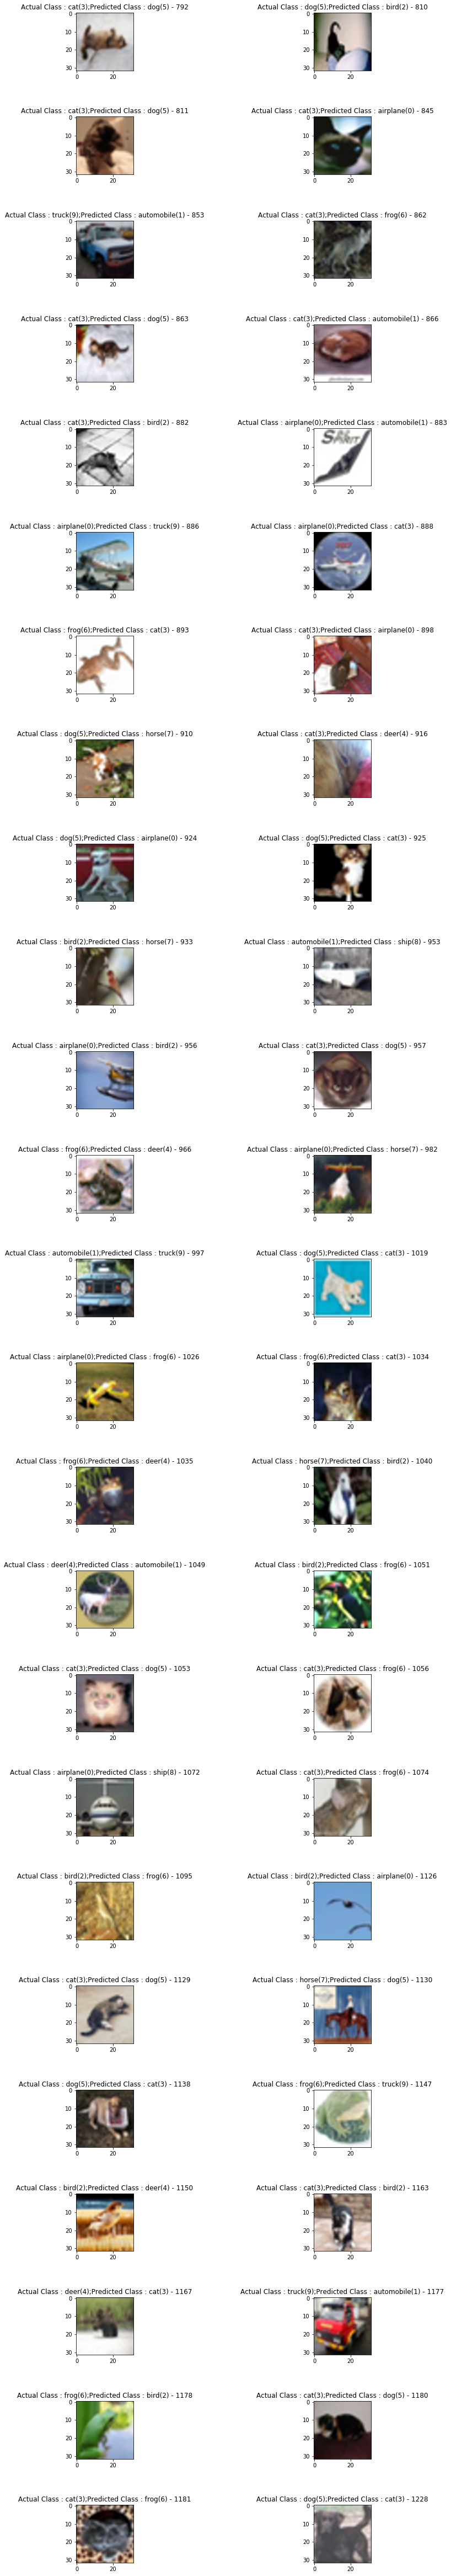

In [82]:
# Image gallery of 50 misclassified images from the validation dataset

import numpy as np
import matplotlib.pyplot as plt

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
x_test_img = x_test + x_train_mean
#x_test_img = x_test_img.astype('float32') * 255

fig=plt.figure(figsize=(85, 85))
columns = 2
rows = 25
idx_list = []
for i in range(1, columns*rows + 1):
    idx = mc_idx[i-1 + 80]
    idx_list.append(idx)
    img = x_test_img.reshape(x_test_img.shape[0], 32, 32, 3)[idx]
    fig.add_subplot(rows, columns, i)
    fig.subplots_adjust(hspace=0.8, wspace= -0.9)
    #plt.title('%d'%prediction_labels[idx])
    #plt.title('%s'%class_names[prediction_labels[idx]])
    plt.title("Actual Class : {}({});Predicted Class : {}({}) - {}".format(class_names[actual_labels[idx]], actual_labels[idx], class_names[prediction_labels[idx]], prediction_labels[idx], idx))
    #ax.set_title(class_names[prediction_labels[idx]])
    plt.imshow(img,interpolation = 'spline16')
    plt.imshow((img * 255).astype(np.uint8), interpolation = 'spline16')
plt.show()

In [83]:
print(len(idx_list))

50


In [0]:
# Import numpy, cv2, sys, Keras image and backend
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [0]:
# Function to obtain class_output from the predictions. Model, features and indexes need to be passed as arguments.

def pred_class_info(model, features, idx):
      img = features.reshape(features.shape[0], 32, 32, 3)[idx]
      img = img.reshape(1, 32, 32, 3)
      preds = model.predict(img)
      class_idx = np.argmax(preds)
      class_output = model.output[:, class_idx]
      return img,class_output

In [0]:
# Function to obtain weighted features map. This takes class ouput, last convoultion layer, image and number of filters as arguments

def weighted_feature_map(model, class_output, last_conv_layer, img, filters):
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([img])

  for i in range(filters):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  return conv_layer_output_value

In [0]:
# Function to generate heatmap from pooled_gradient_values * conv_layer_output

def gen_heatmap(conv_layer_output_value):
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

In [0]:
last_conv_layer = saved_model.get_layer("conv2d_16")

In [89]:
print(last_conv_layer.output)

Tensor("conv2d_16_1/BiasAdd:0", shape=(?, 8, 8, 10), dtype=float32)


In [0]:
# Function to obtain the gradient CAM(Class Activation Map). This takes mode, entire dataset of images, index of the image for which grad CAM is to be generated, layer name and number of filters in that layer

def grad_CAM(model, features, index, layer_nam, num_filters):
  img,class_output = pred_class_info(model, features, index)
  last_conv_layer = model.get_layer(layer_nam)
  
  conv_layer_output_value = weighted_feature_map(model, class_output, last_conv_layer, img, num_filters)
  heatmap = gen_heatmap(conv_layer_output_value)
    
  img = img.reshape(32, 32, 3)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap1 = np.uint8(255 * heatmap)
  heatmap2 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
  heatmap3 = cv2.cvtColor(heatmap2,cv2.COLOR_BGR2RGB)
  img1 = np.uint8(255 * img)
  superimposed_img = cv2.addWeighted(img1, 0.6, heatmap3, 0.4, 0)
  return superimposed_img

In [91]:
print(idx_list)

[792, 810, 811, 845, 853, 862, 863, 866, 882, 883, 886, 888, 893, 898, 910, 916, 924, 925, 933, 953, 956, 957, 966, 982, 997, 1019, 1026, 1034, 1035, 1040, 1049, 1051, 1053, 1056, 1072, 1074, 1095, 1126, 1129, 1130, 1138, 1147, 1150, 1163, 1167, 1177, 1178, 1180, 1181, 1228]


### GradCAM results of misclassified images

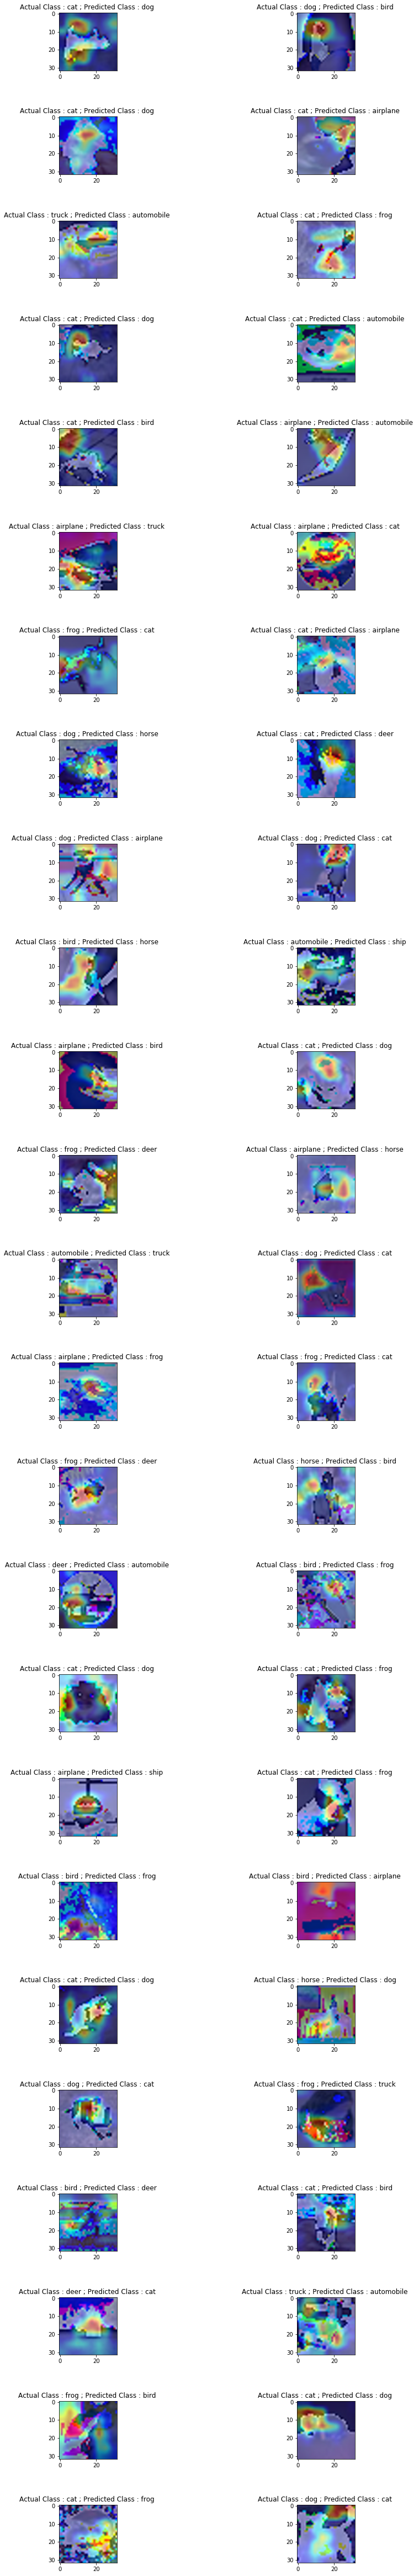

In [92]:
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(85, 85))
columns = 2
rows = 25
for i in range(1, columns*rows + 1):
    idx = idx_list[i-1]
    #img = x_test_img.reshape(x_test_img.shape[0], 32, 32, 3)[idx]
    fig.add_subplot(rows, columns, i)
    fig.subplots_adjust(hspace=0.8, wspace= -0.9)
    #plt.title('%d'%prediction_labels[idx])
    #plt.title('%s'%class_names[prediction_labels[idx]])
    plt.title("Actual Class : {} ; Predicted Class : {} ".format(class_names[actual_labels[idx]],  class_names[prediction_labels[idx]]))
    #ax.set_title(class_names[prediction_labels[idx]])
    gradCAM_img = grad_CAM(saved_model, x_test, idx, "conv2d_16", 10)
    plt.imshow(gradCAM_img,interpolation = 'spline16')
plt.show()